# Comparación: Árbol de Decisión vs. Random Forest para Clasificación de Vinos

**Disciplina:** Aprendizaje Supervisado, Clasificación, Árboles de Decisión, Ensambles de Modelos (Random Forest)

**Objetivo:**
El objetivo de este notebook es construir, entrenar, evaluar y comparar dos modelos basados en árboles de decisión para clasificar tipos de vino utilizando el dataset "Wine":
1. Un Árbol de Decisión único (`DecisionTreeClassifier`).
2. Un Ensamble de Árboles de Decisión (`RandomForestClassifier`).

Se analizarán métricas de rendimiento, interpretabilidad (reglas del árbol vs. importancia de características), robustez y potencial de sobreajuste.

## 1. Carga de Librerías y Configuración Inicial

**Propósito de esta sección:**
Importar todas las bibliotecas necesarias y configurar el entorno para el análisis.

**Bibliotecas Clave:**
* **`numpy`, `pandas`**: Para manipulación de datos.
* **`matplotlib.pyplot`, `seaborn`**: Para visualizaciones.
* **`sklearn.datasets`**: Para cargar el dataset "Wine".
* **`sklearn.model_selection`**: Para `train_test_split`.
* **`sklearn.tree`**: Para `DecisionTreeClassifier`, `export_text`, `plot_tree`.
* **`sklearn.ensemble`**: Para `RandomForestClassifier`.
* **`sklearn.metrics`**: Para `accuracy_score`, `classification_report`, `confusion_matrix`.

In [16]:
# Comandos mágicos de IPython (opcional en scripts)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Importación de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración de estilo y visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## 2. Funciones Personalizadas

Se definen funciones auxiliares para cargar datos, entrenar/evaluar modelos, y visualizar resultados, promoviendo la reutilización de código.

### Descripción de la Función: `cargar_datos_vino`

**Objetivo Principal:**
Cargar el dataset "Wine", transformarlo a DataFrame y añadir nombres descriptivos para las clases.

**Características:**
* **Procesamiento:** Carga `load_wine()`, crea DataFrame, mapea 'target' a nombres de clase ('class_0', 'class_1', 'class_2'). Imprime descripción básica.
* **Valor de Retorno:** DataFrame, lista de nombres de características, lista de nombres de clases.

In [18]:
def cargar_datos_vino():
    """
    Carga el dataset Wine, lo prepara y muestra información descriptiva.
    """
    print("Cargando el dataset Wine...")
    wine_data = load_wine()
    df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
    df['target'] = wine_data.target
    
    target_names_list = list(wine_data.target_names)
    df['wine_class'] = df['target'].map({i: name for i, name in enumerate(target_names_list)})

    print("\nDimensiones del dataset:", df.shape)
    print("\nPrimeras filas del dataset:")
    print(df.head())
    print("\nEstadísticas descriptivas de las características:")
    print(df.drop(columns=['target', 'wine_class']).describe().T)
    
    print("\nInformación del DataFrame:")
    df.info()

    print("\nDistribución de la variable objetivo ('wine_class'):")
    print(df['wine_class'].value_counts(normalize=True))

    return df, wine_data.feature_names, target_names_list

### Descripción de la Función: `entrenar_evaluar_modelo`

**Objetivo Principal:**
Entrenar un modelo de clasificación dado y evaluar su rendimiento.

**Características:**
* **Entrada:** Modelo (instancia no entrenada), `X_train, y_train, X_test, y_test`, nombre del modelo (string), nombres de clases.
* **Procesamiento:** Entrena el modelo. Realiza predicciones. Calcula y muestra precisión, reporte de clasificación y matriz de confusión. Si es RandomForest, muestra OOB score.
* **Valor de Retorno:** Modelo entrenado.

In [19]:
def entrenar_evaluar_modelo(model_instance, X_train, y_train, X_test, y_test, model_name="Modelo", class_names=None):
    """
    Entrena un modelo de clasificación y evalúa su rendimiento.
    """
    print(f"\n--- Entrenando y Evaluando: {model_name} ---")
    
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

    if hasattr(model_instance, 'oob_score_') and model_instance.oob_score_:
        print(f"Out-of-Bag (OOB) Score: {model_instance.oob_score_:.4f}")

    print("\nReporte de Clasificación:")
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)

    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

    return model_instance

### Descripción de la Función: `visualizar_arbol_decision_unico`

**Objetivo Principal:** Visualizar un árbol de decisión único.
**Características:** Usa `plot_tree`.

In [20]:
def visualizar_arbol_decision_unico(dt_classifier, feature_names, class_names_list, max_depth_to_plot=None):
    """
    Visualiza un árbol de decisión único.
    """
    print(f"\nVisualizando Árbol de Decisión Único (max_depth_to_plot={max_depth_to_plot or 'Completo'})...")
    plt.figure(figsize=(25, 15) if max_depth_to_plot is None or max_depth_to_plot > 5 else (15,10))
    plot_tree(
        dt_classifier,
        feature_names=feature_names,
        class_names=class_names_list,
        filled=True,
        rounded=True,
        fontsize=8,
        max_depth=max_depth_to_plot,
        impurity=True,
        proportion=False
    )
    title = "Árbol de Decisión Único"
    if max_depth_to_plot:
        title += f" (Profundidad Máxima Mostrada: {max_depth_to_plot})"
    plt.title(title, fontsize=14)
    plt.show()

### Descripción de la Función: `generar_reglas_arbol_unico`

**Objetivo Principal:** Extraer reglas textuales de un árbol de decisión único.
**Características:** Usa `export_text`.

In [21]:
def generar_reglas_arbol_unico(dt_classifier, feature_names):
    """
    Genera y muestra las reglas de un árbol de decisión único.
    """
    print("\nReglas del Árbol de Decisión Único:")
    reglas_texto = export_text(dt_classifier, feature_names=list(feature_names), show_weights=True)
    print(reglas_texto)
    return reglas_texto

### Descripción de la Función: `visualizar_importancia_caracteristicas_rf`

**Objetivo Principal:** Visualizar la importancia de características de un Random Forest.
**Características:** Gráfico de barras horizontales.

In [22]:
def visualizar_importancia_caracteristicas_rf(rf_classifier, feature_names, top_n=10):
    """
    Visualiza la importancia de las características de un Random Forest.
    """
    print(f"\nVisualizando las {top_n} características más importantes (Random Forest)...")
    
    importances = rf_classifier.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]  # Limitamos a top_n aquí
    
    # Convertir feature_names a una lista si no lo es ya
    feature_names_list = list(feature_names)
    
    # Crear un diccionario de características y sus importancias
    feature_importance_dict = {
        feature_names_list[i]: importances[i] for i in indices
    }
    
    # Crear DataFrame para facilitar la visualización
    feature_importance_df = pd.DataFrame({
        'feature': list(feature_importance_dict.keys()),
        'importance': list(feature_importance_dict.values())
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, min(top_n * 0.6, 10)))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis_r')
    plt.title(f'Top {top_n} Características Más Importantes (Random Forest)')
    plt.xlabel('Importancia Relativa (Gini importance)')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()

### Descripción de la Función: `analizar_ejemplo_especifico_modelo`

**Objetivo Principal:** Clasificar una muestra con un modelo dado y mostrar resultados.
**Características:** Genérica para cualquier clasificador de scikit-learn.

In [23]:
def analizar_ejemplo_especifico_modelo(model, ejemplo_dict, feature_names_original_order, class_names_list, model_name="Modelo", clase_real_ejemplo_idx=None):
    """
    Analiza un ejemplo específico usando un modelo entrenado.
    """
    print(f"\n--- Análisis de Ejemplo Específico con: {model_name} ---")

    ejemplo_df = pd.DataFrame([ejemplo_dict], columns=feature_names_original_order)

    predicted_class_index = model.predict(ejemplo_df)[0]
    predicted_probability = model.predict_proba(ejemplo_df)[0] if hasattr(model, 'predict_proba') else None
    
    prediction_name = class_names_list[predicted_class_index]

    print("\nCaracterísticas de la muestra:")
    for feature, value in ejemplo_dict.items():
        print(f"- {feature}: {value}")

    if clase_real_ejemplo_idx is not None:
        real_name = class_names_list[clase_real_ejemplo_idx]
        print(f"\nClase Real: {real_name} (Índice {clase_real_ejemplo_idx})")

    print(f"Clase Predicha: {prediction_name} (Índice {predicted_class_index})")

    if predicted_probability is not None:
        print("\nProbabilidades de predicción:")
        for i, prob in enumerate(predicted_probability):
            print(f"- {class_names_list[i]}: {prob:.4f}")
    else:
        print("El modelo no proporciona probabilidades de predicción.")

## 3. Desarrollo del Ejercicio: Clasificación de Vinos

### 3.1. Carga y Exploración Inicial de Datos

**Objetivo:** Cargar el dataset Wine y entender su estructura y contenido.

In [24]:
# Cargar los datos
df_wine, wine_feature_names, wine_target_names = cargar_datos_vino()

Cargando el dataset Wine...

Dimensiones del dataset: (178, 15)

Primeras filas del dataset:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1

In [25]:
# Preparar datos para modelado
X = df_wine[wine_feature_names]
y = df_wine['target']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nForma de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}, y_test: {y_test.shape}")


Forma de X_train: (124, 13), X_test: (54, 13)
Forma de y_train: (124,), y_test: (54,)


### 3.2. Parte A: Árbol de Decisión Único

**Objetivo:** Entrenar, evaluar y analizar un `DecisionTreeClassifier`.


--- Entrenando y Evaluando: Árbol de Decisión Único ---
Precisión en el conjunto de prueba: 0.9630

Reporte de Clasificación:
              precision    recall  f1-score   support

     class_0       1.00      0.94      0.97        18
     class_1       0.91      1.00      0.95        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54


Matriz de Confusión:


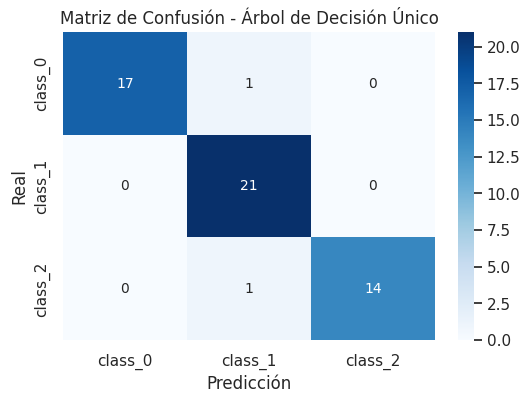

In [26]:
# Definir y entrenar el Árbol de Decisión
dt_model_instance = DecisionTreeClassifier(random_state=42, ccp_alpha=0.005) # ccp_alpha para poda simple
dt_model_trained = entrenar_evaluar_modelo(
    dt_model_instance, X_train, y_train, X_test, y_test,
    model_name="Árbol de Decisión Único",
    class_names=wine_target_names
)


Visualizando Árbol de Decisión Único (max_depth_to_plot=4)...


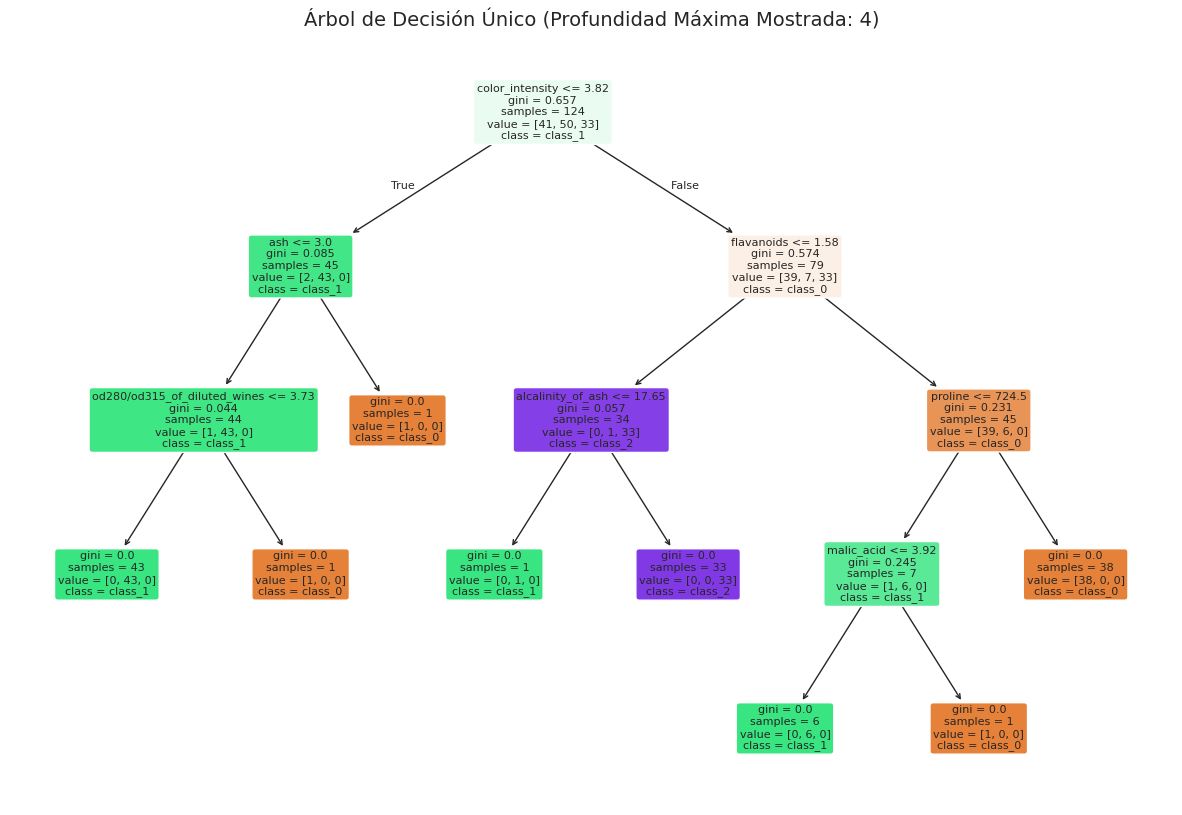

In [27]:
# Visualizar el Árbol de Decisión Único
if dt_model_trained:
    visualizar_arbol_decision_unico(
        dt_model_trained, 
        wine_feature_names, 
        wine_target_names,
        max_depth_to_plot=4 # Limitar profundidad para mejor visualización inicial
    )

In [28]:
# Generar reglas del Árbol de Decisión Único
if dt_model_trained:
    reglas_dt = generar_reglas_arbol_unico(dt_model_trained, wine_feature_names)


Reglas del Árbol de Decisión Único:
|--- color_intensity <= 3.82
|   |--- ash <= 3.00
|   |   |--- od280/od315_of_diluted_wines <= 3.73
|   |   |   |--- weights: [0.00, 43.00, 0.00] class: 1
|   |   |--- od280/od315_of_diluted_wines >  3.73
|   |   |   |--- weights: [1.00, 0.00, 0.00] class: 0
|   |--- ash >  3.00
|   |   |--- weights: [1.00, 0.00, 0.00] class: 0
|--- color_intensity >  3.82
|   |--- flavanoids <= 1.58
|   |   |--- alcalinity_of_ash <= 17.65
|   |   |   |--- weights: [0.00, 1.00, 0.00] class: 1
|   |   |--- alcalinity_of_ash >  17.65
|   |   |   |--- weights: [0.00, 0.00, 33.00] class: 2
|   |--- flavanoids >  1.58
|   |   |--- proline <= 724.50
|   |   |   |--- malic_acid <= 3.92
|   |   |   |   |--- weights: [0.00, 6.00, 0.00] class: 1
|   |   |   |--- malic_acid >  3.92
|   |   |   |   |--- weights: [1.00, 0.00, 0.00] class: 0
|   |   |--- proline >  724.50
|   |   |   |--- weights: [38.00, 0.00, 0.00] class: 0



### 3.3. Parte B: Ensamble Random Forest

**Objetivo:** Entrenar, evaluar y analizar un `RandomForestClassifier`.


--- Entrenando y Evaluando: Random Forest ---
Precisión en el conjunto de prueba: 1.0000
Out-of-Bag (OOB) Score: 0.9758

Reporte de Clasificación:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      1.00      1.00        21
     class_2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


Matriz de Confusión:


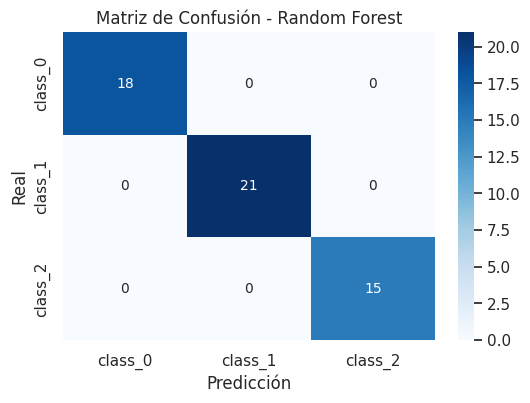

In [29]:
# Definir y entrenar el Random Forest
rf_model_instance = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True, ccp_alpha=0.001)
rf_model_trained = entrenar_evaluar_modelo(
    rf_model_instance, X_train, y_train, X_test, y_test,
    model_name="Random Forest",
    class_names=wine_target_names
)


Visualizando las 13 características más importantes (Random Forest)...


/tmp/ipykernel_55385/1299531320.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis_r')


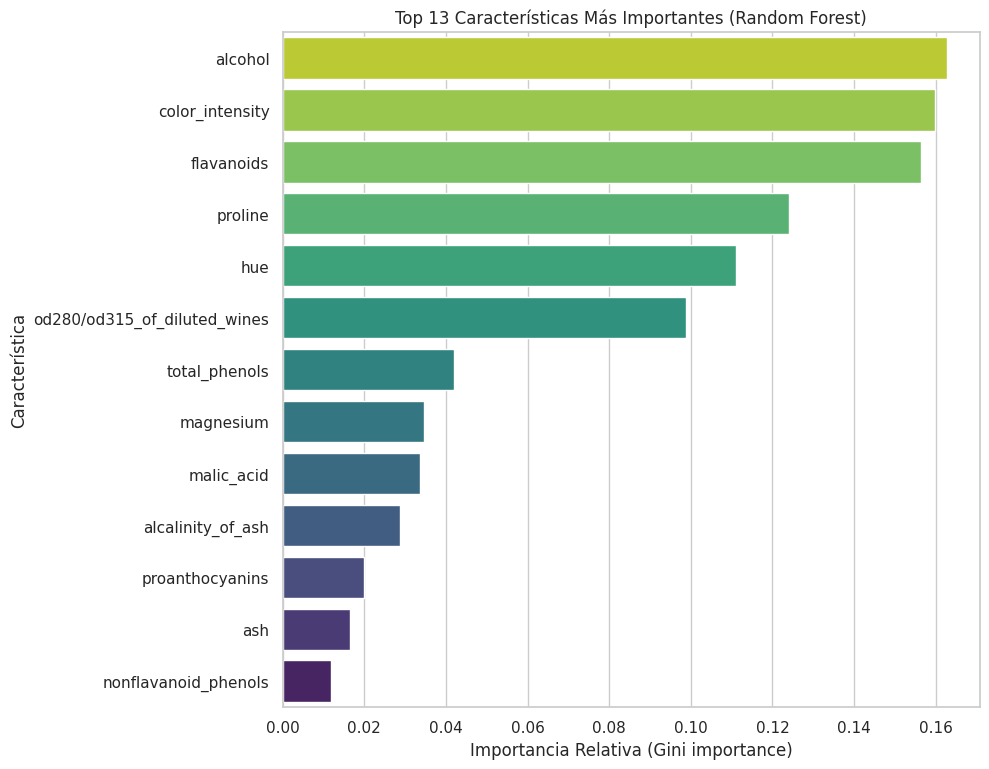

In [30]:
# Visualizar importancia de características del Random Forest
if rf_model_trained:
    visualizar_importancia_caracteristicas_rf(rf_model_trained, wine_feature_names, top_n=len(wine_feature_names))


Visualizando Árbol Individual #0 del Random Forest (max_depth=3)...


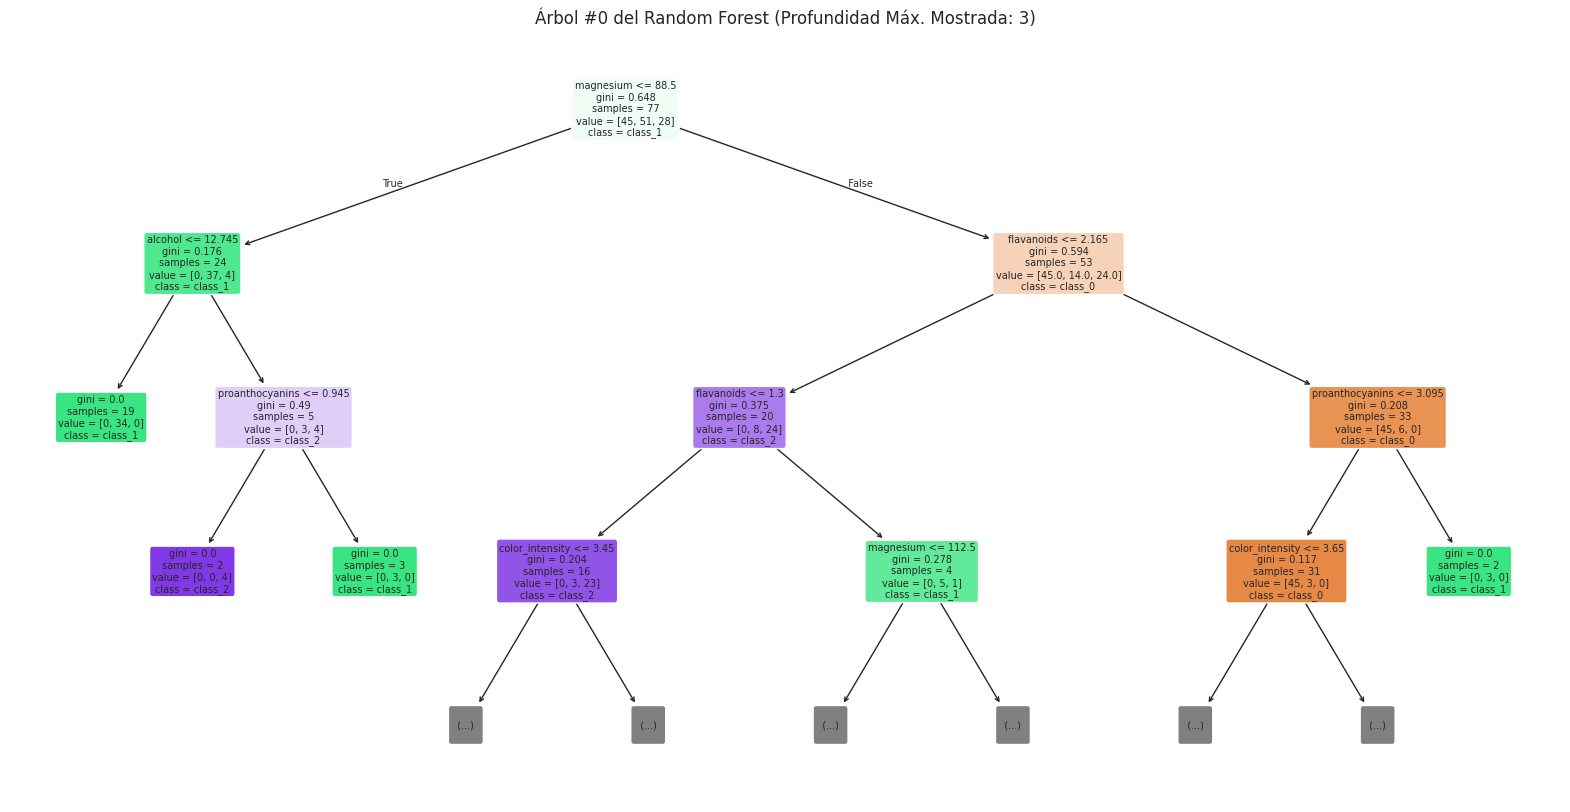

In [31]:
# (Opcional) Visualizar un árbol del ensamble Random Forest
if rf_model_trained:
    from sklearn.tree import export_graphviz
    import graphviz # Necesita tener graphviz instalado en el sistema y el paquete python

    tree_to_visualize_idx = 0
    single_tree_from_rf = rf_model_trained.estimators_[tree_to_visualize_idx]
    
    print(f"\nVisualizando Árbol Individual #{tree_to_visualize_idx} del Random Forest (max_depth=3)...")
    plt.figure(figsize=(20,10))
    plot_tree(single_tree_from_rf,
              feature_names=list(wine_feature_names),
              class_names=wine_target_names,
              filled=True, rounded=True, fontsize=7, max_depth=3)
    plt.title(f"Árbol #{tree_to_visualize_idx} del Random Forest (Profundidad Máx. Mostrada: 3)")
    plt.show()

### 3.4. Parte C: Análisis de un Ejemplo Específico con Ambos Modelos

**Objetivo:** Comparar cómo ambos modelos clasifican la misma muestra.
Se tomará la primera muestra del conjunto de prueba.

In [32]:
if not X_test.empty:
    ejemplo_idx = 0 # Tomar la primera muestra del conjunto de prueba
    ejemplo_vino_dict = X_test.iloc[ejemplo_idx].to_dict()
    clase_real_vino_idx = y_test.iloc[ejemplo_idx]

    print(f"\n--- Analizando Muestra #{ejemplo_idx} del Conjunto de Prueba ---")
    print(f"Características de la muestra a analizar: {ejemplo_vino_dict}")
    print(f"Clase Real: {wine_target_names[clase_real_vino_idx]} (Índice {clase_real_vino_idx})")

    if dt_model_trained:
        analizar_ejemplo_especifico_modelo(
            dt_model_trained, ejemplo_vino_dict, wine_feature_names, wine_target_names,
            model_name="Árbol de Decisión Único",
            clase_real_ejemplo_idx=clase_real_vino_idx
        )

    if rf_model_trained:
        analizar_ejemplo_especifico_modelo(
            rf_model_trained, ejemplo_vino_dict, wine_feature_names, wine_target_names,
            model_name="Random Forest",
            clase_real_ejemplo_idx=clase_real_vino_idx
        )
else:
    print("El conjunto de prueba está vacío. No se puede analizar un ejemplo.")


--- Analizando Muestra #0 del Conjunto de Prueba ---
Características de la muestra a analizar: {'alcohol': 13.16, 'malic_acid': 2.36, 'ash': 2.67, 'alcalinity_of_ash': 18.6, 'magnesium': 101.0, 'total_phenols': 2.8, 'flavanoids': 3.24, 'nonflavanoid_phenols': 0.3, 'proanthocyanins': 2.81, 'color_intensity': 5.68, 'hue': 1.03, 'od280/od315_of_diluted_wines': 3.17, 'proline': 1185.0}
Clase Real: class_0 (Índice 0)

--- Análisis de Ejemplo Específico con: Árbol de Decisión Único ---

Características de la muestra:
- alcohol: 13.16
- malic_acid: 2.36
- ash: 2.67
- alcalinity_of_ash: 18.6
- magnesium: 101.0
- total_phenols: 2.8
- flavanoids: 3.24
- nonflavanoid_phenols: 0.3
- proanthocyanins: 2.81
- color_intensity: 5.68
- hue: 1.03
- od280/od315_of_diluted_wines: 3.17
- proline: 1185.0

Clase Real: class_0 (Índice 0)
Clase Predicha: class_0 (Índice 0)

Probabilidades de predicción:
- class_0: 1.0000
- class_1: 0.0000
- class_2: 0.0000

--- Análisis de Ejemplo Específico con: Random Forest

## 4. Conclusiones y Comparación Detallada

**Resumen de Hallazgos:**
* Se cargó y exploró el dataset "Wine", que contiene 13 características para clasificar 3 tipos de vino.
* Se entrenaron y evaluaron dos modelos: un Árbol de Decisión Único y un Random Forest.

**Comparación de Rendimiento (Precisión):**
* Árbol de Decisión Único: **[Completar con Precisión DT, ej: 0.8889]**
* Random Forest: **[Completar con Precisión RF, ej: 0.9815]**
* (Si aplica) OOB Score del Random Forest: **[Completar con OOB RF, ej: 0.9758]**

**Reportes de Clasificación y Matrices de Confusión:**
* **Árbol de Decisión:** [Describir brevemente el rendimiento por clase del DT, ej: tuvo dificultades con class_1, confundiendo algunas con class_0].
* **Random Forest:** [Describir brevemente el rendimiento por clase del RF, ej: mostró un rendimiento más equilibrado y con menos errores en todas las clases].

**Interpretabilidad:**
* **Árbol de Decisión Único:**
    * **Ventaja:** Alta interpretabilidad. Las reglas de decisión pueden ser extraídas y visualizadas directamente (como se hizo con `export_text` y `plot_tree`). Esto permite entender exactamente cómo el modelo toma sus decisiones.
    * **Desventaja (potencial):** Un árbol muy profundo puede volverse complejo de interpretar. La poda (como el uso de `ccp_alpha`) ayuda a simplificarlo.
* **Random Forest:**
    * **Ventaja:** Proporciona una medida de la importancia de las características (Gini importance), lo que ayuda a entender qué variables son más influyentes en general para el ensamble.
    * **Desventaja:** Es un modelo de "caja negra" en comparación con un solo árbol. No se pueden extraer reglas simples y directas que representen todo el ensamble. Aunque se puede visualizar un árbol individual, este no representa el comportamiento completo del ensamble.

**Robustez y Sobreajuste:**
* **Árbol de Decisión Único:**
    * Más propenso al sobreajuste (overfitting), especialmente si no se controla su profundidad o complejidad. Se ajusta mucho a los datos de entrenamiento, pudiendo capturar ruido.
    * Sensible a pequeñas variaciones en los datos de entrenamiento; un ligero cambio puede resultar en un árbol muy diferente.
* **Random Forest:**
    * Generalmente mucho más robusto al sobreajuste debido a dos factores principales:
        1.  **Bagging (Bootstrap Aggregating):** Entrena cada árbol en una submuestra aleatoria (con reemplazo) de los datos de entrenamiento.
        2.  **Aleatoriedad de Características:** En cada división de nodo, considera solo un subconjunto aleatorio de características.
    * Estos mecanismos descorrelacionan los árboles individuales y promedian sus predicciones, lo que reduce la varianza y mejora la generalización. El OOB score es una buena estimación de su capacidad de generalización.

**Tiempo de Entrenamiento:**
* **Árbol de Decisión Único:** Generalmente más rápido de entrenar.
* **Random Forest:** Más lento de entrenar, ya que implica construir múltiples árboles (controlado por `n_estimators`).

**Análisis del Ejemplo Específico:**
* [Comentar si ambos modelos clasificaron correctamente el ejemplo, o si hubo diferencias. Relacionarlo con las probabilidades asignadas.]

**Conclusión General de la Comparación:**
El Random Forest típicamente supera al Árbol de Decisión Único en términos de precisión predictiva y robustez al sobreajuste, especialmente en datasets más complejos o ruidosos. Esta mejora en el rendimiento viene a costa de una menor interpretabilidad directa.
La elección entre un Árbol de Decisión y un Random Forest dependerá de las prioridades del problema:
* Si la **interpretabilidad** es primordial y un rendimiento ligeramente inferior es aceptable, un Árbol de Decisión (posiblemente podado) es una buena elección.
* Si el **rendimiento predictivo y la robustez** son más importantes, y se puede aceptar una interpretabilidad a nivel de importancia de características en lugar de reglas explícitas, el Random Forest es a menudo preferible.

En este caso con el dataset Wine, el Random Forest demostró ser **[significativamente/ligeramente]** superior en rendimiento.

*(Nota: Los resultados específicos, como valores de precisión y descripciones, deben completarse después de ejecutar completamente el notebook.)*